Multiclass classification!

So instead of a binary problem, we now have a > 2 class problem! 
(think 3 colors instead of 2)

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from helper_functions import plot_decision_boundary
from sklearn.datasets import make_blobs
A = torch.arange(-10, 10, 1)

In [3]:
#Calculating accuracy. Out of 100 examples, what percentage does our model get right?

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy

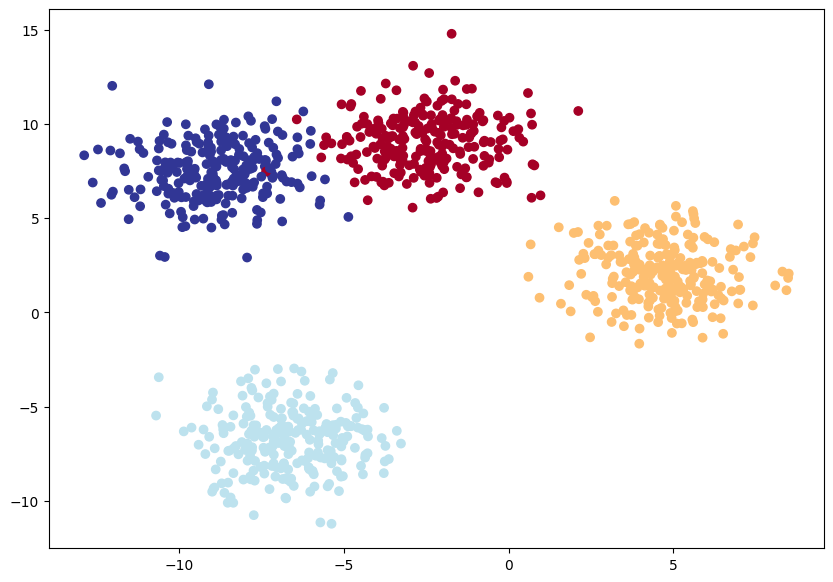

In [4]:
NUM_CLASSES = 4
NUM_FEATURES = 2 #determines the elements in each array.
RANDOM_SEED = 42

#This is what a multi-class data might look like: 
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, #this is a 
                            random_state=RANDOM_SEED)

#turn this dataset into tensors:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#split train & test:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, 
                                                                        test_size=0.2, 
         
                                                                        random_state=RANDOM_SEED)

#this visualization is good for seeing clusters
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [10]:
#building our model

class blobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):

        """"
        We are going to pass in these Args:
        input_features - number of inpout features to the model
        output_features - number of output featuures
        hidden_unit - hidden layers (default 8)
                
        """

        super().__init__()
        #when our model is called, the data is passed through these layers in sequence
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_0 = blobModel(input_features = 2, 
                    output_features = 4, 
                    hidden_units=8)

model_0

blobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [7]:
#loss_fn + optimizer! 

loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.SGD(params=model_0.parameters(), lr=0.1)



## CrossEntropyLoss

"This criterion computes the cross entropy loss between input logits and target."

Input being our data, and target being our output feature!

**"weight"** describes the amount of data each class has. In our case, the weight is distributed equally.

In [8]:
#TRAINING OUR DATAAAAAAA

epochs = 1000

for epoch in range(epochs):

    model_0.train()

    y_train_logits = model_0(X_blob_train) #raw output -> logits
    y_train_predProbs = torch.softmax(y_train_logits, dim=1).argmax(dim=1) #normalized output, by softmax activation function

    '''the reason why we don't add softmax layer into our model, is because of how computers and its memory work
    placing our softmax function here will generate more accurate results (little round-off errors), compared to adding 
    the softmax layer in our model (Andrew Ng)

    conceptually, they are the same thing.
    '''

    loss = loss_fn(y_train_logits, y_blob_train)
    acc_score = accuracy_fn(y_blob_train, y_train_predProbs)

    """
    **We need to input a long datype in to the loss_fn, because CrossEntropyLoss simply requires so
    
    """

    optim.zero_grad()
    loss.backward()
    optim.step()
    #omg remember to put parantheses in your optim.step(). if not it will only train the same data over and over 

    #TEST

    model_0.eval()

    with torch.inference_mode():
        y_test_logits = model_0(X_blob_test)
        y_test_predProbs = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(y_test_logits,y_blob_test)
        acc_score_test = accuracy_fn(y_blob_test, y_test_predProbs)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc_score:.5f}% | Test Loss: {test_loss:.2f} | Test accuracy: {acc_score_test:.2f}%")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (800x8 and 9x8)

tensor(1.0000, grad_fn=<SumBackward0>)

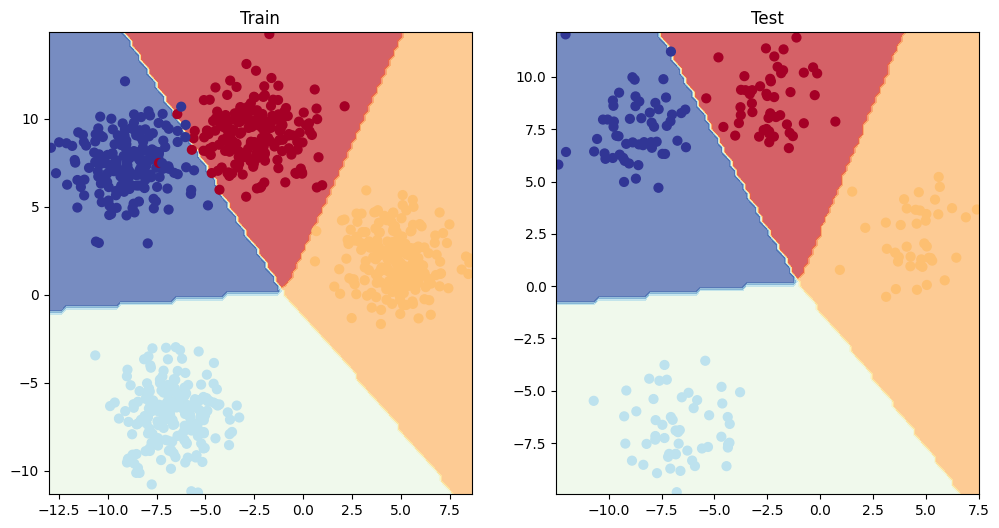

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test)

y_test_logits = model_0(X_blob_test)
y_normalized = torch.softmax(y_test_logits,dim=1)
y_normalized[0].sum()


## logits vs. normalized vs. argmax visualized

ok so we know logits is the **raw** output from the model.

and we need an activation function to normalize it (make the data legible for us). In this case, it is the **probablity** of the class. How many % is the model sure that it is that specific class.

After normalizing, we compare within the array and see which **class** does the model gives the most probability. We can use argmax, to give us the **index** of which value is the largest within that array.

Let's say we have the first row of data, where 
`[3.1183e-06, 1.0000e+00, 1.4778e-10, 1.8964e-09]`. The argmax of this array is 1. Cause the largest value, "1" is at index position 1. 
(note that the sum of these = 1, because we are comparing probability)

In [8]:
#logits vs. normalized vs. argmax

#logits
y_test_logits[:10]

tensor([[  1.1315,  13.8447,  -1.0025, -10.7161],
        [  0.2358, -14.2861,  -1.0646,   8.8180],
        [-10.2985,  -1.8952,   7.6741,  -3.3597],
        [  0.1646,   9.3745,  -0.3950,  -7.3166],
        [ 11.0918,   0.9917,  -6.1257,  -1.5085],
        [ -0.1366, -17.5818,  -1.0496,  10.9429],
        [ -9.0553,  -1.6411,   6.7420,  -2.9985],
        [  8.9073,  -2.0091,  -4.6726,   0.1958],
        [-12.7826,  -2.3392,   9.5342,  -4.1202],
        [  9.5749,  -0.8765,  -5.0431,  -0.5057]], grad_fn=<SliceBackward0>)

In [9]:
#normalized
y_test_normalized = torch.softmax(y_test_logits, dim=1)
y_test_normalized[:10]

tensor([[3.0109e-06, 1.0000e+00, 3.5641e-07, 2.1546e-11],
        [1.8737e-04, 9.2457e-11, 5.1045e-05, 9.9976e-01],
        [1.5652e-08, 6.9839e-05, 9.9991e-01, 1.6146e-05],
        [1.0004e-04, 9.9984e-01, 5.7160e-05, 5.6374e-08],
        [9.9996e-01, 4.1070e-05, 3.3303e-08, 3.3707e-06],
        [1.5424e-05, 4.0911e-13, 6.1902e-06, 9.9998e-01],
        [1.3779e-07, 2.2864e-04, 9.9971e-01, 5.8840e-05],
        [9.9982e-01, 1.8153e-05, 1.2654e-06, 1.6465e-04],
        [2.0320e-10, 6.9735e-06, 9.9999e-01, 1.1749e-06],
        [9.9993e-01, 2.8906e-05, 4.4822e-07, 4.1883e-05]],
       grad_fn=<SliceBackward0>)

In [10]:
#argmax
y_test_normalized.argmax(dim=1)[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

If we removed the ReLU layer, we find that the model is still able to classify our data accurately. But that's just because our data can already be split using straight lines!

If our data is not like that, the model might have issues with accuracy. 

## Classification metrics!!!! (to determine the reliability of our model)

1. Accuracy
2. Precision
3. Recall 
4. F1-score
5. Confusing Matrix
6. Classification report

After this we can **improve** our model.

- adding layers
- increasing number of hidden units
- change/add activation functions
- change optimization functions
- change learning rate

In [16]:
from torchmetrics import Accuracy


In [22]:
torch_accuracy = Accuracy(task='multiclass', num_classes =4)
torch_accuracy(y_test_predProbs, y_blob_test)*100
#same as ouru own defined function!

tensor(99.5000)

In [96]:
import numpy as np
def canPlaceFlowers(self, flowerbed: list[int], n: int) -> bool:
    #count number of 0s in array
    #count % n must be 0
    num_zeros =  len(flowerbed)-np.count_nonzero(flowerbed)
    print(num_zeros)
    if num_zeros % n == 0 and n % 2 == 0:
        return True
    return False
canPlaceFlowers(self=any,flowerbed=[1,0,0,0,0,1],n=2)

4


True

In [102]:
merged = [1,2,3,4]
for i in range(1,len(merged)-1):
    print(merged[i+1])

3
4
